In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

# Plot styling (same as before)
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 120,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "font.family": "sans-serif"
})

# Matplotlib formatter (two args) — keep this for matplotlib axes
def rupee_formatter_matplotlib(x, pos):
    try:
        return f"₹{x:,.0f}"
    except Exception:
        return str(x)

currency_formatter = FuncFormatter(rupee_formatter_matplotlib)

# Pandas formatter (single arg) — use this with df.style.format(...)
def rupee_format_value(x):
    try:
        # convert to float first to handle numeric types; then format
        return f"₹{float(x):,.0f}"
    except Exception:
        return x


In [2]:
# Creates or overwrites the database in the notebook working directory
DB_FILENAME = "sales_data.db"
conn = sqlite3.connect(DB_FILENAME)
cur = conn.cursor()

# Re-create table (idempotent run)
cur.execute("DROP TABLE IF EXISTS sales;")
cur.execute("""
CREATE TABLE sales (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    product TEXT NOT NULL,
    quantity INTEGER NOT NULL,
    price REAL NOT NULL,
    sale_date TEXT NOT NULL
)
""")

# Sample rows (you can replace or extend these)
sample_data = [
    ("Laptop", 5, 70000, "2025-09-01"),
    ("Laptop", 3, 70000, "2025-09-03"),
    ("Mobile", 10, 25000, "2025-09-02"),
    ("Mobile", 7, 25000, "2025-09-04"),
    ("Headphones", 15, 1500, "2025-09-01"),
    ("Headphones", 20, 1500, "2025-09-05"),
    ("Tablet", 6, 30000, "2025-09-02"),
    ("Tablet", 4, 30000, "2025-09-03")
]

cur.executemany("INSERT INTO sales (product, quantity, price, sale_date) VALUES (?, ?, ?, ?);", sample_data)
conn.commit()
print(f"Database `{DB_FILENAME}` created and sample data inserted.")


Database `sales_data.db` created and sample data inserted.


In [7]:
query_product = """
SELECT product,
       SUM(quantity)       AS total_qty,
       SUM(quantity*price) AS total_revenue
FROM sales
GROUP BY product
ORDER BY total_revenue DESC;
"""

df_product = pd.read_sql_query(query_product, conn)
df_product['total_qty'] = df_product['total_qty'].astype(int)
df_product['total_revenue'] = df_product['total_revenue'].astype(float).astype(int)

print("\n Product-level summary:")
display(df_product.style.format({
    "total_qty": "{:,}",
    "total_revenue": rupee_format_value
}))

# Save to CSV
df_product.to_csv("sales_summary_by_product.csv", index=False)



 Product-level summary:


,product,total_qty,total_revenue
0,Laptop,8,"₹560,000"
1,Mobile,17,"₹425,000"
2,Tablet,10,"₹300,000"
3,Headphones,35,"₹52,500"


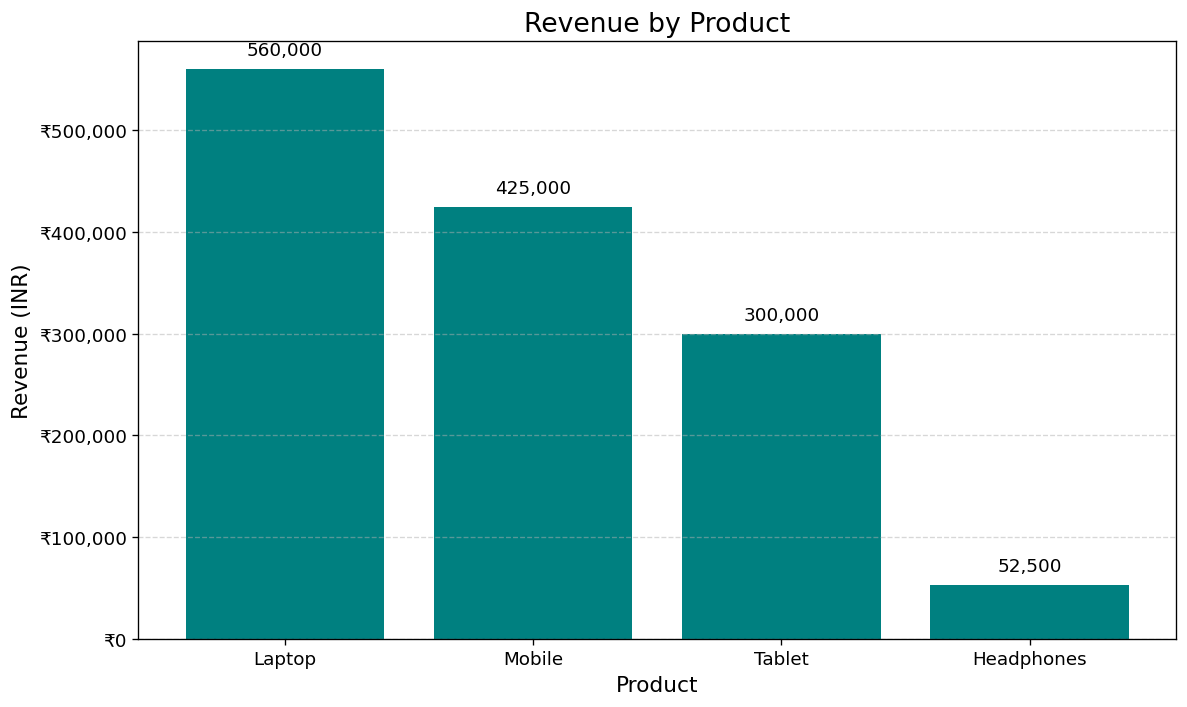

In [8]:
fig, ax = plt.subplots()
bars = ax.bar(df_product['product'], df_product['total_revenue'], color="teal")
ax.set_title("Revenue by Product")
ax.set_xlabel("Product")
ax.set_ylabel("Revenue (INR)")
ax.yaxis.set_major_formatter(currency_formatter)
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height:,.0f}",
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 6),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("revenue_by_product.png", dpi=150)
plt.show()



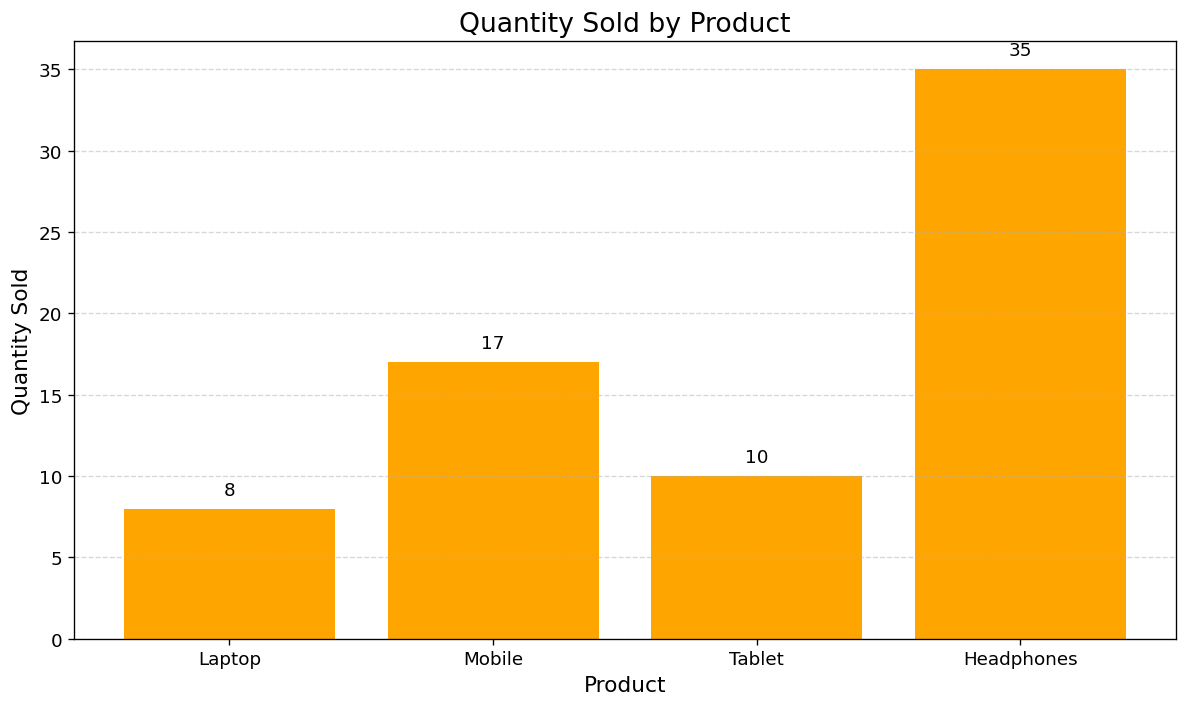

In [9]:
fig, ax = plt.subplots()
bars = ax.bar(df_product['product'], df_product['total_qty'], color="orange")
ax.set_title("Quantity Sold by Product")
ax.set_xlabel("Product")
ax.set_ylabel("Quantity Sold")
ax.grid(axis="y", linestyle="--", alpha=0.5)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height:,}",
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 6),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("quantity_by_product.png", dpi=150)
plt.show()


In [10]:
query_daily = """
SELECT sale_date,
       SUM(quantity*price) AS daily_revenue
FROM sales
GROUP BY sale_date
ORDER BY sale_date;
"""

df_daily = pd.read_sql_query(query_daily, conn)
df_daily['sale_date'] = pd.to_datetime(df_daily['sale_date'])
df_daily['daily_revenue'] = df_daily['daily_revenue'].astype(float).astype(int)

print("\n📅 Daily revenue:")
display(df_daily.style.format({"daily_revenue": rupee_format_value}))

df_daily.to_csv("daily_revenue.csv", index=False)




📅 Daily revenue:


,sale_date,daily_revenue
0,2025-09-01 00:00:00,"₹372,500"
1,2025-09-02 00:00:00,"₹430,000"
2,2025-09-03 00:00:00,"₹330,000"
3,2025-09-04 00:00:00,"₹175,000"
4,2025-09-05 00:00:00,"₹30,000"


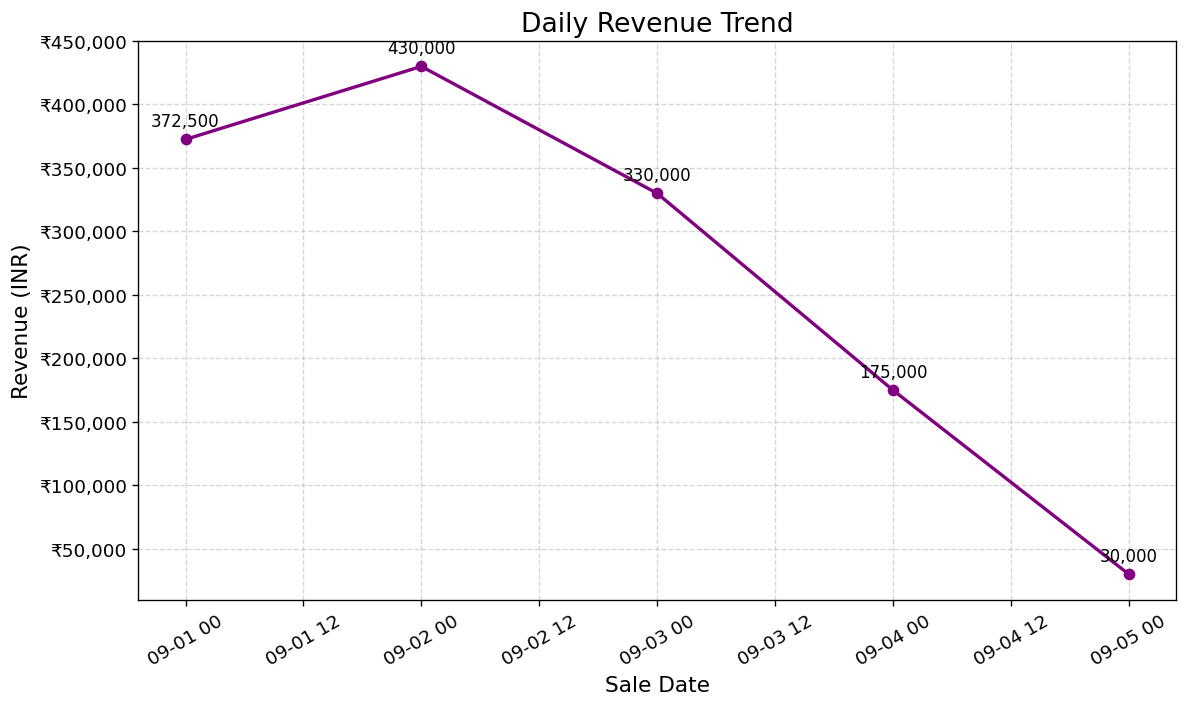


 Analysis complete. CSV and PNG files saved in current directory.


In [12]:
fig, ax = plt.subplots()
ax.plot(df_daily['sale_date'], df_daily['daily_revenue'], marker='o', linewidth=2, color="purple")
ax.set_title("Daily Revenue Trend")
ax.set_xlabel("Sale Date")
ax.set_ylabel("Revenue (INR)")
ax.yaxis.set_major_formatter(currency_formatter)
ax.grid(True, linestyle="--", alpha=0.5)

# Annotate points
for x, y in zip(df_daily['sale_date'], df_daily['daily_revenue']):
    ax.annotate(f"{y:,.0f}", xy=(x, y), xytext=(0, 8),
                textcoords="offset points", ha="center", fontsize=10)

plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("daily_revenue.png", dpi=150)
plt.show()


# 8. Close DB
conn.close()
print("\n Analysis complete. CSV and PNG files saved in current directory.")